# Regression with Neural Networks

So far we have only looked at classification problems, where the target output is one of several class labels. In regression the target value is a real-valued quantity, and this adds significant challenges to the model. The optimization process tends to be more difficult because the model needs to predict the direction *and* the magnitude of the output. In addition, regression modeling requires a non-trivial choice of loss function and how to represent uncertainty. 

For a no-code introduction, see the regression problem in [Tensorflow Playground](https://playground.tensorflow.org/#activation=tanh&batchSize=2&dataset=circle&regDataset=reg-gauss&learningRate=1&regularizationRate=0&noise=0&networkShape=7,7,7&seed=0.02239&showTestData=false&discretize=false&percTrainData=10&x=true&y=true&xTimesY=false&xSquared=false&ySquared=false&cosX=false&sinX=false&cosY=false&sinY=false&collectStats=false&problem=regression&initZero=false&hideText=false).


# Imports

We will need the following libraries.

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

# Dataset

Here we define a simple dataset. **Heteroskedastic** means that the variance of the output changes for different inputs. Note that the relationship between X and y is nonlinear, so a simple linear regression model will not work well.

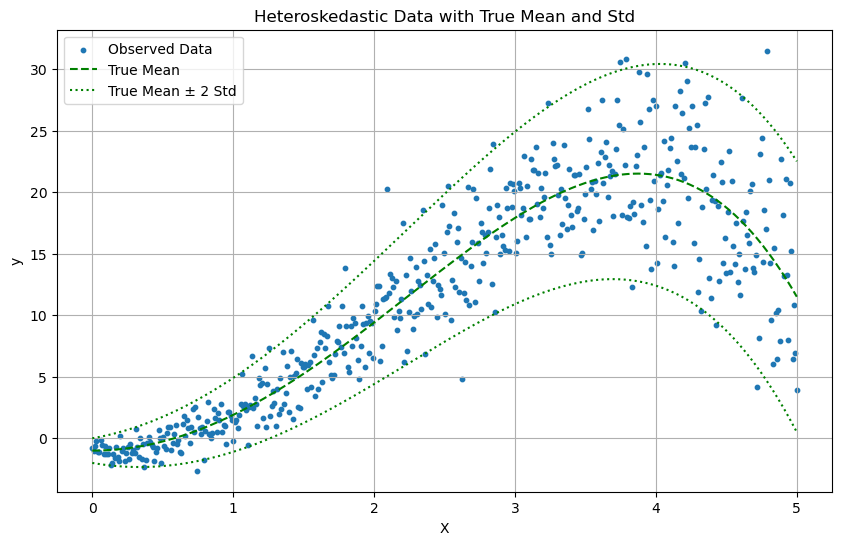

In [16]:


# Generate Synthetic Heteroskedastic Data
def generate_heteroskedastic_data(n_samples=500):
    """
    Generates synthetic data with heteroskedastic noise.

    Args:
        n_samples (int): Number of data points to generate.  Defaults to 500.

    Returns:
        tuple: (X, y, true_mean, true_std)
            X: Input features (n_samples, 1)
            y: Target values (n_samples, 1)
            true_mean:  The true underlying mean function.
            true_std:   The true standard deviation function.
    """
    np.random.seed(42)
    X = np.linspace(0, 5, n_samples).reshape(-1, 1)
    true_mean = -0.1 *X**4 + 3.0* X**2 - 1
    true_std = 0.5 + np.abs(X)  # Standard deviation increases with |X|
    noise = np.random.normal(0, true_std, size=(n_samples, 1))
    y = true_mean + noise
    return X, y, true_mean, true_std



# Generate Data
X, y, true_mean, true_std = generate_heteroskedastic_data()

# Plot the data, true mean and std
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=10, label='Observed Data')
plt.plot(X, true_mean, 'g--', label='True Mean')
plt.plot(X, true_mean + 2 * true_std, 'g:', label='True Mean ± 2 Std')
plt.plot(X, true_mean - 2 * true_std, 'g:')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Heteroskedastic Data with True Mean and Std')
plt.legend()
plt.grid(True)
plt.show()

# Model Definition

We define a simple NN that has two outputs. The first output predicts the mean and the second output predicts the standard deviation. 

In [19]:
# Define the Heteroskedastic Neural Network Model
class HeteroskedasticNN(nn.Module):
    """
    A neural network that predicts both the mean and standard deviation
    of the target variable, allowing it to model heteroskedasticity.
    """
    def __init__(self, input_dim, hidden_units=32):
        """
        Initializes the neural network.

        Args:
            input_dim (int): The number of input features.
            hidden_units (int): Number of hidden units in the layer.
        """
        super(HeteroskedasticNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_units)
        self.relu = nn.ReLU()
        self.fc_mean = nn.Linear(hidden_units, 1)  # Output for the mean
        self.fc_std_unscaled = nn.Linear(hidden_units, 1) # Output for unscaled std

    def forward(self, x):
        """
        Forward pass through the network.

        Args:
            x (torch.Tensor): Input tensor of shape (batch_size, input_dim)

        Returns:
            tuple: (mean, std)
                mean: Predicted mean (batch_size, 1)
                std: Predicted standard deviation (batch_size, 1)
        """
        x = self.relu(self.fc1(x))
        mean = self.fc_mean(x)
        # Ensure standard deviation is positive using softplus
        std = nn.functional.softplus(self.fc_std_unscaled(x)) + 1e-6 # Add small constant for numerical stability
        return mean, std


# Loss Function

Now we define a loss function. We define the loss to be the negative log-likelihood function. This *maximizes* the probability of the observed target value y under the probabilistic model

$$p(y|x) = \mathcal{N}(y; \mu_\theta(X), \sigma_\theta(X))$$

where $\mu_\theta(X), \sigma_\theta(X)$ are the two outputs of the neural network. In regular regression (non-heteroskedastic), minimizing the mean squared error (MSE) implicitly uses this loss function, just with the assumption of a fixed variance parameter.

In [20]:
# Define the Negative Log-Likelihood Loss Function
def heteroskedastic_loss(mean, std, target):
    """
    Calculates the negative log-likelihood loss for a Gaussian distribution.

    Args:
        mean (torch.Tensor): Predicted mean.
        std (torch.Tensor): Predicted standard deviation.
        target (torch.Tensor): True target values.

    Returns:
        torch.Tensor: The mean negative log-likelihood.
    """
    # Calculate the negative log-likelihood of a Gaussian distribution
    nll = 0.5 * torch.log(2 * torch.pi * std**2) + 0.5 * (target - mean)**2 / std**2
    return torch.mean(nll)


# Optimization

As usual, we train the model with gradient descent. All the same tricks apply to training, but the optimization tends to be more difficult. See if you can obtain good results by tuning the learning parameters.


Epoch [20/200], Loss: 2.9559
Epoch [40/200], Loss: 2.6449
Epoch [60/200], Loss: 2.5753
Epoch [80/200], Loss: 2.3521
Epoch [100/200], Loss: 2.6082
Epoch [120/200], Loss: 2.6926
Epoch [140/200], Loss: 2.3224
Epoch [160/200], Loss: 2.5693
Epoch [180/200], Loss: 2.6100
Epoch [200/200], Loss: 2.7552


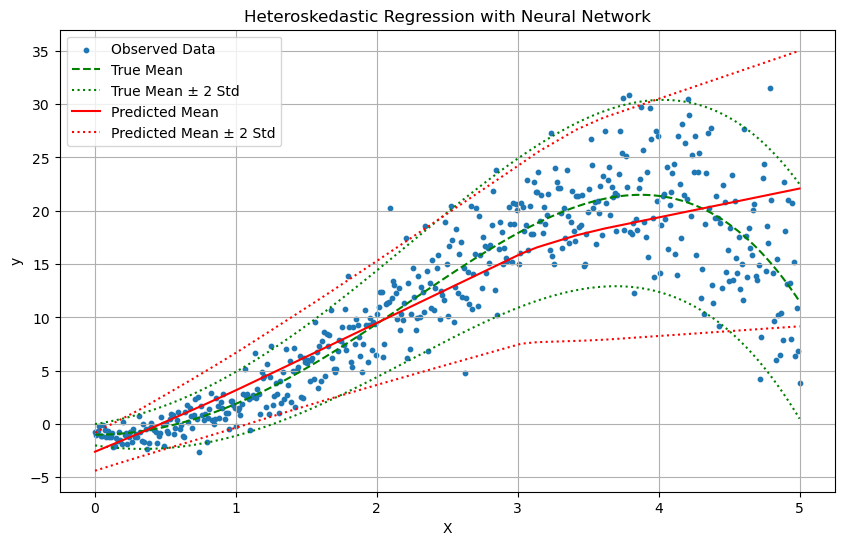

In [22]:

# Train the Model
def train_heteroskedastic_model(model, dataloader, epochs=200, learning_rate=0.01, print_every=20):
    """
    Trains the heteroskedastic neural network model.

    Args:
        model (nn.Module): The neural network model to train.
        dataloader (DataLoader):  DataLoader providing training data.
        epochs (int): Number of training epochs. Defaults to 200.
        learning_rate (float): Learning rate for the optimizer. Defaults to 0.01.
        print_every (int):  Frequency (in epochs) to print the training loss.
    """
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        model.train()
        for inputs, targets in dataloader:
            optimizer.zero_grad()
            predicted_mean, predicted_std = model(inputs)
            loss = heteroskedastic_loss(predicted_mean, predicted_std, targets)
            loss.backward()
            optimizer.step()
        if (epoch + 1) % print_every == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

# Make Predictions and Visualize the Results
def plot_heteroskedastic_results(model, X, y, true_mean, true_std):
    """
    Makes predictions with the trained model and visualizes the results.

    Args:
        model (nn.Module): Trained neural network model.
        X (np.ndarray): Input features.
        y (np.ndarray): Target values.
        true_mean (np.ndarray): The true underlying mean function.
        true_std (np.ndarray): The true standard deviation function.
    """
    model.eval()
    X_torch = torch.tensor(X, dtype=torch.float32)
    with torch.no_grad():
        predicted_mean, predicted_std = model(X_torch)
        predicted_mean = predicted_mean.numpy()
        predicted_std = predicted_std.numpy()

    # Plot the data, true mean and std, and predicted mean and std
    plt.figure(figsize=(10, 6))
    plt.scatter(X, y, s=10, label='Observed Data')
    plt.plot(X, true_mean, 'g--', label='True Mean')
    plt.plot(X, true_mean + 2 * true_std, 'g:', label='True Mean ± 2 Std')
    plt.plot(X, true_mean - 2 * true_std, 'g:')
    plt.plot(X, predicted_mean, 'r-', label='Predicted Mean')
    plt.plot(X, predicted_mean + 2 * predicted_std, 'r:', label='Predicted Mean ± 2 Std')
    plt.plot(X, predicted_mean - 2 * predicted_std, 'r:')
    plt.xlabel('X')
    plt.ylabel('y')
    plt.title('Heteroskedastic Regression with Neural Network')
    plt.legend()
    plt.grid(True)
    plt.show()
    
# Define Model
input_dim = X.shape[1]
model = HeteroskedasticNN(input_dim)

# Train Model
X_torch = torch.tensor(X, dtype=torch.float32)
y_torch = torch.tensor(y, dtype=torch.float32)
dataset = TensorDataset(X_torch, y_torch)
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

train_heteroskedastic_model(model, dataloader)

# Plot Results
plot_heteroskedastic_results(model, X, y, true_mean, true_std)

# Strategies for improvement

Predicting multiple outputs at once can cause instabilities in training. There is some ML work arguing that it is better to train the mean prediction "head" first, then fix the parameters of that part of the network while training the variance prediction head. Part of this strategy is to have different "arms" of the network. Taken to the extreme, you create two separate networks: one predicting the mean and one the variance.

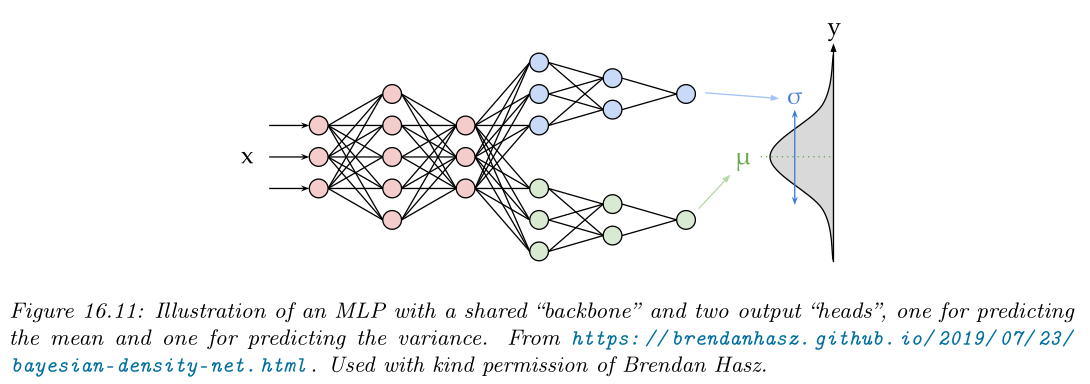

# Multiple Output Variables

In many science applications, we want to predict multiple output variables, such as temperature at many locations on a grid. Or temperature *and* pressure. One simplest solution is to use a separate regression model for each output variable. But can we do better?

We can use the same strategy as demonstrated above to predict multiple outputs at once. One advantage is that this may be more convenient. A second advantage is that the same features learned for one task can be re-used for another task. This is a form of transfer learning, which could in theory help learn faster with less overfitting for a finite amount of training data. However, if we think about the loss function, the probabilistic model still assume independence between the output variables, an assumption that is almost certainly false for most climate applications.

## Joint Distributions

We would really like to model the joint probability distribution of multiple outputs. This is a difficult thing to do, requiring a lot more training data and computational resources. However, the latest generative AI models for text and images address this issue and can be applied to science applications.
